### Spacecraft positions for movies, now plots

This notebook demonstrates ways of getting positions with spiceypy, e.g. for position movies since 2020 or for current position plots

use spiceypy for positions at Bepi, PSP, Solo, STEREO-A, JUICE, L4, L5 and the inner 4 planets

https://spiceypy.readthedocs.io/en/stable/

product:

- file with positions in rad, 10 min resolution, since 2020, with matplotlib datenumbers
"results/positions/positions_2020_all_HEEQ_10min_rad_cm.p"

- file with positions in rad, 1 hour resolution, since 2020, with matplotlib datenumbers
"results/positions/positions_2020_all_HEEQ_1h_rad_cm.p"


- 10 min version used for "now" plot (data_update_web_hf.ipynb)
- 1h version used for position movies for context with other missions (position_movies.ipynb)


#### Orbits:

need to copy these updated kernel files manually to the kernel paths, and change filenames in code (!)
- SolO Kernels are available at:  https://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/spk/
then change filename in solo_furnish

- PSP https://soho.nascom.nasa.gov/solarsoft/psp/gen/data/spice/orbit/
use file like "spp_nom_20180812_20300101_v042_PostV7.bsp" and change filename in psp_furnish

- BepiColombo https://naif.jpl.nasa.gov/pub/naif/BEPICOLOMBO/kernels/spk/, use latest file and change filename in bepi_furnish

- JUICE  https://spiftp.esac.esa.int/data/SPICE/JUICE/kernels/ files like: juice_orbc_000080_230414_310721_v01.bsp

- generic kernels https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/

- STEREO-A

all: https://soho.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/


for science data: https://soho.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/ahead/

predicted: https://soho.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/epm/ahead/



In [1]:


#dt=24 #hours, for 1 day


#dt=1/6 #hours for 10 min
#filename='results/positions/positions_2020_all_HEEQ_10min_rad_cm.p'

dt=1 #hours, for 1 hour
filename='results/positions/positions_2020_all_HEEQ_1h_rad_cm.p'



import numpy as np
import pandas as pd
import scipy
import scipy.io
import scipy.signal
import copy
import os
import sys
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import time
import datetime
import urllib
from urllib.request import urlopen
import requests
import json
from sunpy.time import parse_time
from sunpy.coordinates import HeliocentricInertial, HeliographicStonyhurst, HeliocentricEarthEcliptic
import astropy
import astropy.units as u
from astropy.constants import au
from astropy.time import Time, TimeDelta
import pickle
import cdflib
import spiceypy
import math
import h5py


#Plotly imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px


import importlib

if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import solo_path    
    from config_server import psp_path 
    from config_server import bepi_path  
    from config_server import stereoa_path
    from config_server import kernels_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import solo_path 
    from config_local import bepi_path 
    from config_local import psp_path 
    from config_local import stereoa_path
    from config_local import kernels_path 
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    #matplotlib.use('Agg') 
    
def cart2sphere_emma_rad(x,y,z):
    
    r = np.sqrt(x**2+ y**2 + z**2) /1.495978707E8         
    theta = np.arctan2(z,np.sqrt(x**2+ y**2)) * 360 / 2 / np.pi
    phi = np.arctan2(y,x) * 360 / 2 / np.pi    
    
    theta=np.deg2rad(theta)
    phi=np.deg2rad(phi)
    
    return (r, theta, phi)



#Convert this notebook to a script 
os.system('jupyter nbconvert --to script positions.ipynb')   


#measure runtime
t0=time.time()

 
------ PATHS 
system is mac


[NbConvertApp] Converting notebook positions.ipynb to script
[NbConvertApp] Writing 45581 bytes to positions.py


#### define times

In [2]:
# Start date

# Start date
start_date = datetime.datetime(2020, 4, 1)

# End date
end_date_bepi = datetime.datetime(2027, 1, 1)

end_date_all = datetime.datetime(2030, 1, 1)


# List to store the datetimes
times_bepi = []
times = [] 
times_mes=[]
times_juice=[]



# Generate datetimes with increments of dt hours until the end date
current_date = start_date
while current_date <= end_date_bepi:
    times_bepi.append(current_date)
    current_date += datetime.timedelta(hours=dt)

    
# Generate datetimes with increments of dt hours until the end date
current_date = start_date
while current_date <= end_date_all:
    times.append(current_date)
    current_date += datetime.timedelta(hours=dt)

    



####JUICE

# Start date
start_date_juice = datetime.datetime(2023, 4, 15)

end_date_juice = datetime.datetime(2031, 7, 21)

    
# Generate datetimes with increments of dt hours until the end date
current_date = start_date_juice
while current_date <= end_date_all:
    times_juice.append(current_date)
    current_date += datetime.timedelta(hours=dt)

# Print the generated datetimes
#for dt in datetimes:
print(times_bepi[-1])
print(times[-1])
print(times_juice[-1])


2027-01-01 00:00:00
2030-01-01 00:00:00
2030-01-01 00:00:00


### BepiColombo

bc_mpo_fcp_00199_20181020_20270407_v02.bsp
['de442.bsp', 'heliospheric_v004u.tf', '.DS_Store', 'naif0012.tls', 'pck00010.tpc']
/Users/chris/python/data/kernels/


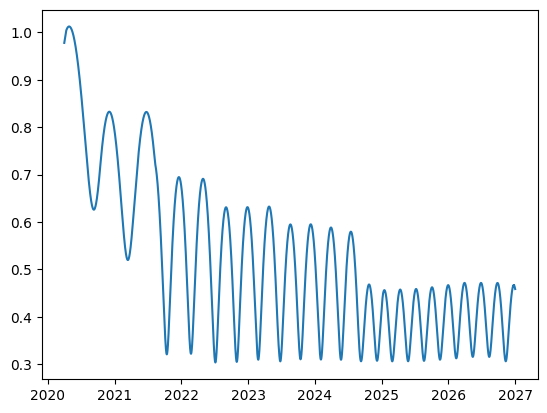

In [3]:
#from hd.data          
##Bepi POSITION FUNCTIONS with spiceypy, preferred method
#https://naif.jpl.nasa.gov/pub/naif/BEPICOLOMBO/kernels/spk/
def bepi_furnish(kernels_path):
    """Main"""
    bepi_path = kernels_path+'bepi/'
  
    #put the latest file here manually
    bepi_kernel = 'bc_mpo_fcp_00199_20181020_20270407_v02.bsp'
    spiceypy.furnsh(os.path.join(bepi_path, bepi_kernel))
    print(bepi_kernel)

    #for kernel in solo_kernels:
    #    spiceypy.furnsh(os.path.join(solo_path, kernel))
    #spiceypy.furnsh(solo_kernels)

    
    #bepi_kernels = astrospice.SPKKernel(bepi_path+'bc_mpo_fcp_00199_20181020_20270407_v02.bsp')    
    
    generic_path = kernels_path+'generic/'  
    generic_kernels = os.listdir(generic_path)
    print(generic_kernels)
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))


def get_bepi_pos(t,kernels_path):
    if spiceypy.ktotal('ALL') < 1:
        bepi_furnish(kernels_path)
    pos = spiceypy.spkpos("BEPICOLOMBO MPO", spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_bepi_positions(time_series,kernels_path):
    positions = []
    for t in time_series:
        position = get_bepi_pos(t,kernels_path)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions


    
bepi_furnish(kernels_path)    
print(kernels_path)
bepi=get_bepi_positions(times_bepi,kernels_path)
bepi.time=mdates.date2num(bepi.time)
plt.plot_date(bepi.time,bepi.r,'-')



## Parker Solar Probe

/Users/chris/python/data/kernels/


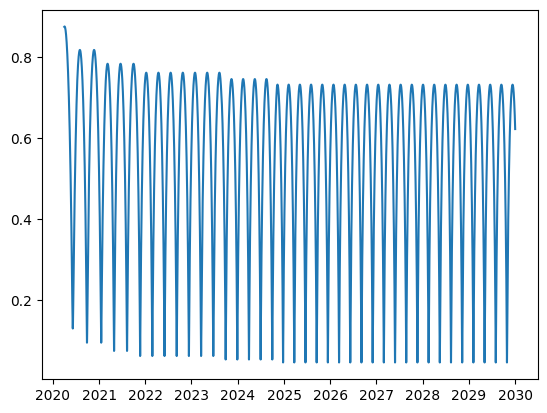

In [4]:
def psp_furnish(kernel_path):

    psp_kernel_path = kernel_path+'psp/'
    generic_path = kernel_path+'generic/'
    
    #psp_kernels = os.listdir(psp_kernel_path)
    #for kernel in psp_kernels:
    #    spiceypy.furnsh(os.path.join(psp_kernel_path, kernel))

    psp_kernel = 'spp_nom_20180812_20300101_v042_PostV7.bsp'
    spiceypy.furnsh(os.path.join(psp_kernel_path, psp_kernel))
    
    generic_kernels = os.listdir(generic_path)
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))
        

def get_psp_pos(t,kernel_path):    
    #if spiceypy.ktotal('ALL') < 1:
    #    psp_furnish(kernel_path)        

    pos = spiceypy.spkpos("PARKER SOLAR PROBE", spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_psp_positions(time_series,kernel_path):
    positions = []
   
    for t in time_series:
        position = get_psp_pos(t,kernel_path)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions



psp_furnish(kernels_path)    
print(kernels_path)
psp=get_psp_positions(times,kernels_path)
psp.time=mdates.date2num(psp.time)
plt.plot_date(psp.time,psp.r,'-')

##  Solar Orbiter


solo_ANC_soc-orbit-stp_20200210-20301120_353_V1_00424_V01.bsp
['de442.bsp', 'heliospheric_v004u.tf', '.DS_Store', 'naif0012.tls', 'pck00010.tpc']
/Users/chris/python/data/kernels/


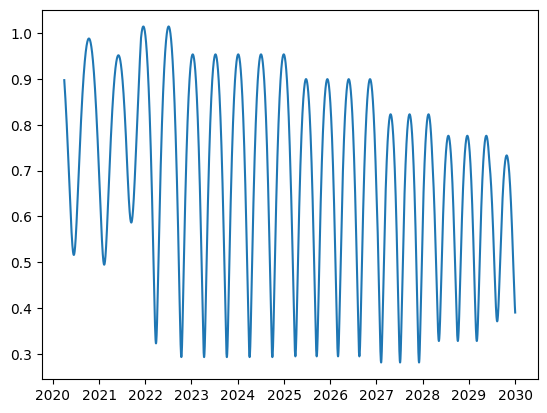

In [5]:
def solo_furnish(kernels_path):
    """Main"""
    solo_path = kernels_path+'solo/'
    #put the latest file here manually
  
    #put the latest file here manually
    solo_kernel = 'solo_ANC_soc-orbit-stp_20200210-20301120_353_V1_00424_V01.bsp'
    spiceypy.furnsh(os.path.join(solo_path, solo_kernel))
    print(solo_kernel)
    
    generic_path = kernels_path+'generic/'
    generic_kernels = os.listdir(generic_path)
    print(generic_kernels)
    #for kernel in solo_kernels:
    #    spiceypy.furnsh(os.path.join(solo_path, kernel))
    #spiceypy.furnsh(solo_kernels)
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))


def get_solo_pos(t,kernels_path):
    if spiceypy.ktotal('ALL') < 1:
        solo_furnish(kernels_path)
    pos = spiceypy.spkpos("SOLAR ORBITER", spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_solo_positions(time_series,kernels_path):
    positions = []
    for t in time_series:
        position = get_solo_pos(t,kernels_path)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions

solo_furnish(kernels_path)    
print(kernels_path)
solo=get_solo_positions(times,kernels_path)

solo.time=mdates.date2num(solo.time)
plt.plot_date(solo.time,solo.r,'-')
           

## STEREO-A

/Users/chris/python/data/kernels/


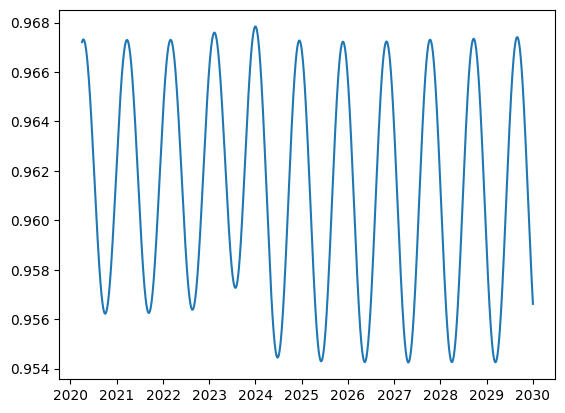

In [6]:
def stereoa_furnish(kernel_path):
    """Main"""
    
    #for science data the past kernels are fine
    #stereo_kernel_path = kernel_path+'stereoa/'
    
    #for positions need predicted kernels
    stereo_kernel_path = kernel_path+'stereoa_predicted/'

    stereoa_kernels = os.listdir(stereo_kernel_path)
    for kernel in stereoa_kernels:
        spiceypy.furnsh(os.path.join(stereo_kernel_path, kernel))
    
    
    generic_path = kernel_path+'generic/'
    generic_kernels = os.listdir(generic_path)
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))


def get_stereoa_pos(t,kernel_path):
    if spiceypy.ktotal('ALL') < 1:
        stereoa_furnish(kernel_path)
    pos = spiceypy.spkpos("STEREO AHEAD", spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_stereoa_positions(time_series,kernel_path):
    positions = []
    for t in time_series:
        position = get_stereoa_pos(t,kernel_path)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions


stereoa_furnish(kernels_path)    
print(kernels_path)
sta=get_stereoa_positions(times,kernels_path)
sta.time=mdates.date2num(sta.time)
plt.plot_date(sta.time,sta.r,'-')



## JUICE


juice_orbc_000080_230414_310721_v01.bsp
/Users/chris/python/data/kernels/


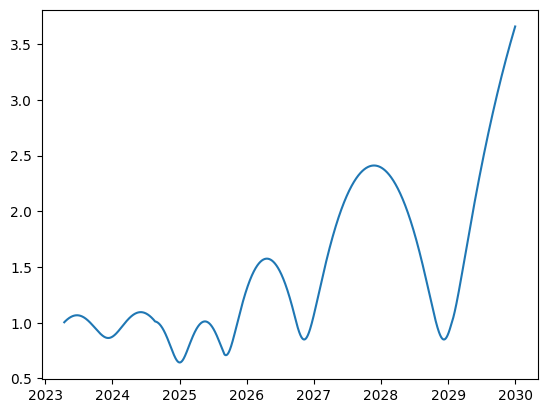

In [7]:
def juice_furnish(kernel_path):
    """Main"""
    
    juice_path = kernels_path+'juice/'
    #put the latest file here manually
  
    #put the latest file here manually
    juice_kernel = 'juice_orbc_000080_230414_310721_v01.bsp'
    spiceypy.furnsh(os.path.join(juice_path, juice_kernel))
    print(juice_kernel)

def get_juice_pos(t,kernel_path):
    if spiceypy.ktotal('ALL') < 1:
        juice_furnish(kernel_path)
    pos = spiceypy.spkpos("JUICE", spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_juice_positions(time_series,kernel_path):
    positions = []
    for t in time_series:
        position = get_juice_pos(t,kernel_path)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions


juice_furnish(kernels_path)    
print(kernels_path)
juice=get_juice_positions(times_juice,kernels_path)
juice.time=mdates.date2num(juice.time)
plt.plot_date(juice.time,juice.r,'-')


## Planets

['de442.bsp', 'heliospheric_v004u.tf', '.DS_Store', 'naif0012.tls', 'pck00010.tpc']
/Users/chris/python/data/kernels/


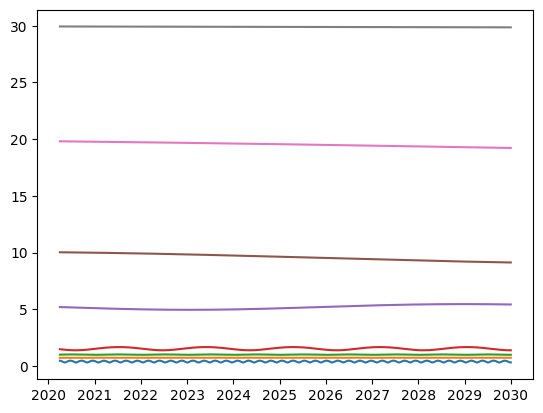

In [12]:
def generic_furnish(kernels_path):
    generic_path = kernels_path+'generic/'  
    generic_kernels = os.listdir(generic_path)
    print(generic_kernels)    
    spiceypy.furnsh(os.path.join(generic_path, 'de442.bsp'))
        
    #for kernel in generic_kernels:
    #    spiceypy.furnsh(os.path.join(generic_path, kernel))
        
def get_planet_pos(t,kernels_path, planet):
    if spiceypy.ktotal('ALL') < 1:
        generic_furnish(kernels_path)
    pos = spiceypy.spkpos(planet, spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position

def get_planet_positions(time_series,kernels_path,planet):
    positions = []
    for t in time_series:
        position = get_planet_pos(t,kernels_path, planet)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions


generic_furnish(kernels_path)    
print(kernels_path)
mercury=get_planet_positions(times,kernels_path, 'MERCURY_BARYCENTER')
venus=get_planet_positions(times,kernels_path, 'VENUS_BARYCENTER')
earth=get_planet_positions(times,kernels_path, 'EARTH_BARYCENTER')
mars=get_planet_positions(times,kernels_path, 'MARS_BARYCENTER')

jupiter=get_planet_positions(times,kernels_path, 'JUPITER_BARYCENTER')
saturn=get_planet_positions(times,kernels_path, 'SATURN_BARYCENTER')
uranus=get_planet_positions(times,kernels_path, 'URANUS_BARYCENTER')
neptune=get_planet_positions(times,kernels_path, 'NEPTUNE_BARYCENTER')


#to matplotlib datenumber
mercury.time=mdates.date2num(mercury.time)
venus.time=mdates.date2num(venus.time)
earth.time=mdates.date2num(earth.time)
mars.time=mdates.date2num(mars.time)
jupiter.time=mdates.date2num(jupiter.time)
saturn.time=mdates.date2num(saturn.time)
uranus.time=mdates.date2num(uranus.time)
neptune.time=mdates.date2num(neptune.time)


plt.plot_date(mercury.time,mercury.r,'-')
plt.plot_date(venus.time,venus.r,'-')
plt.plot_date(earth.time,earth.r,'-')
plt.plot_date(mars.time,mars.r,'-')
plt.plot_date(jupiter.time,jupiter.r,'-')
plt.plot_date(saturn.time,saturn.r,'-')
plt.plot_date(uranus.time,uranus.r,'-')
plt.plot_date(neptune.time,neptune.r,'-')




### Lagrange points L4/L5

['L1_de431.bsp', 'L2_de431.bsp', 'L4_de431.bsp', 'L5_de431.bsp']


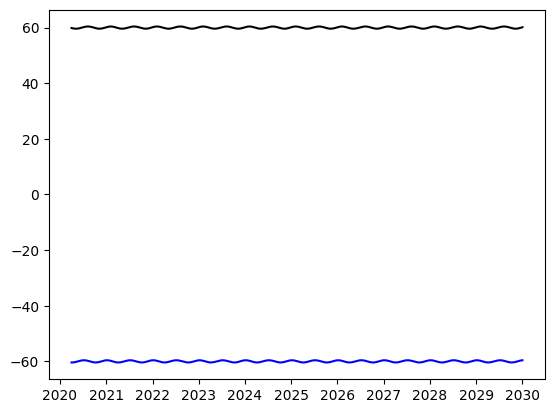

In [26]:
def lagrange_furnish(kernels_path):
    generic_path = kernels_path+'lagrange/'  
    generic_kernels = os.listdir(generic_path)
    print(generic_kernels)    
        
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))
        
def get_lagrange_pos(t,kernels_path, lpoint):
    pos = spiceypy.spkpos(lpoint, spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position

def get_lagrange_positions(time_series,kernels_path,lpoint):
    positions = []
    for t in time_series:
        position = get_lagrange_pos(t,kernels_path, lpoint)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions

lagrange_furnish(kernels_path)
l4=get_lagrange_positions(times,kernels_path, '394') #L4
l5=get_lagrange_positions(times,kernels_path, '395') #L5
l4.time=mdates.date2num(l4.time)
l5.time=mdates.date2num(l5.time)

plt.plot_date(l4.time,np.rad2deg(l4.lon),'k-')
plt.plot_date(l5.time,np.rad2deg(l5.lon),'b-')


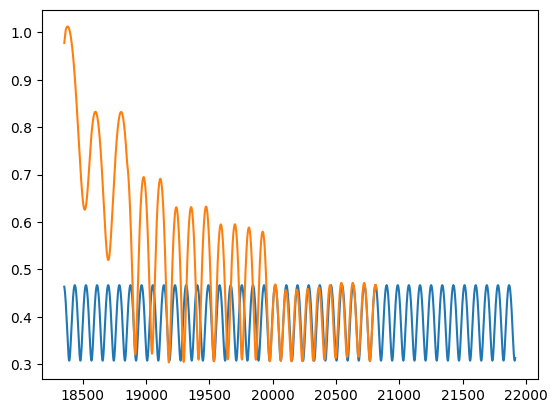

In [27]:

#%matplotlib

plt.plot(mercury.time,mercury.r)
plt.plot(bepi.time,bepi.r)


In [28]:
##make a plotly plot

#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(8,10), dpi=150)
    
#nrows=1
#fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True)

#fig.add_trace(go.Scatter(x=mdates.num2date(mercury.time), y=mercury.r, name='Mercury', line_color='orange' ) )

#fig.add_trace(go.Scatter(x=mdates.num2date(bepi.time), y=bepi.r, name='Bepi',line_color='purple') )


#fig.write_html(f'positions_plotly.html')
#fig.show()






# overview plots

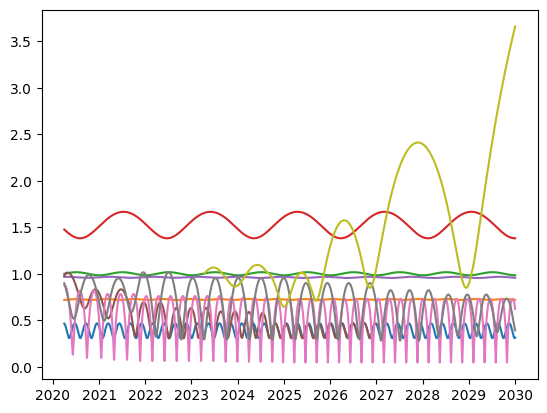

In [29]:
plt.plot_date(mercury.time,mercury.r,'-')
plt.plot_date(venus.time,venus.r,'-')
plt.plot_date(earth.time,earth.r,'-')
plt.plot_date(mars.time,mars.r,'-')
plt.plot_date(sta.time,sta.r,'-')
plt.plot_date(bepi.time,bepi.r,'-')
plt.plot_date(psp.time,psp.r,'-')
plt.plot_date(solo.time,solo.r,'-')
plt.plot_date(juice.time,juice.r,'-')



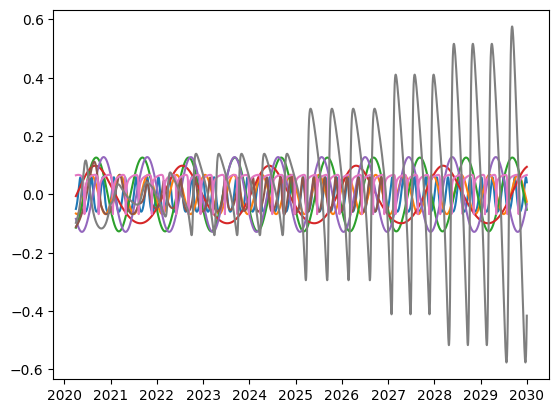

In [30]:
plt.plot_date(mercury.time,mercury.lat,'-')
plt.plot_date(venus.time,venus.lat,'-')
plt.plot_date(earth.time,earth.lat,'-')
plt.plot_date(mars.time,mars.lat,'-')
plt.plot_date(sta.time,sta.lat,'-')
plt.plot_date(bepi.time,bepi.lat,'-')
plt.plot_date(psp.time,psp.lat,'-')
plt.plot_date(solo.time,solo.lat,'-')

## write file with all positions from 2020 onwards

for "now" plot on the homepage, 10 min resolution, rad



In [31]:


##maybe need to convert times to matplotlib date numbers?

pos = np.array([psp, bepi, solo, sta, juice, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune, l4, l5])
pickle.dump(pos, open(filename, 'wb'))

t1 = time.time()
print('making positions takes', np.round((t1-t0)/60,2), 'minutes')
print('merged positions file made')   
    



making positions takes 14.21 minutes
merged positions file made


/var/folders/tr/3wb8vxgd5sj97xz5dz09q0qm0000gn/T/ipykernel_10144/1049210163.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



merged positions loaded


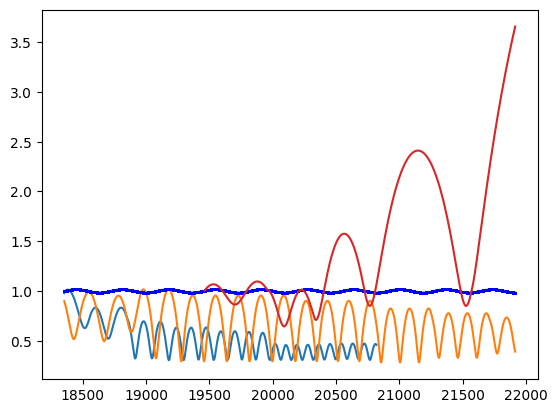

In [32]:
[psp, bepi, solo, sta, juice, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune, l4, l5]=pickle.load( open(filename, "rb" ) )    
print('merged positions loaded')

plt.plot(bepi.time,bepi.r)
plt.plot(solo.time,solo.r)
plt.plot(earth.time,earth.r)
plt.plot(l5.time,l5.r,'ob', markersize=1)
plt.plot(juice.time,juice.r)



In [33]:
earth.time


0        18353.000000
1        18353.041667
2        18353.083333
3        18353.125000
4        18353.166667
             ...     
85484    21914.833333
85485    21914.875000
85486    21914.916667
85487    21914.958333
85488    21915.000000
Name: time, Length: 85489, dtype: float64

## JUNO


### MESSENGER

this seems to be the right file for the cruise phase
https://naif.jpl.nasa.gov/pub/naif/pds/data/mess-e_v_h-spice-6-v1.0/messsp_1000/

msgr_040803_110601_120401_od216sc.bsp
['de442.bsp', 'heliospheric_v004u.tf', '.DS_Store', 'naif0012.tls', 'pck00010.tpc']
/Users/chris/python/data/kernels/


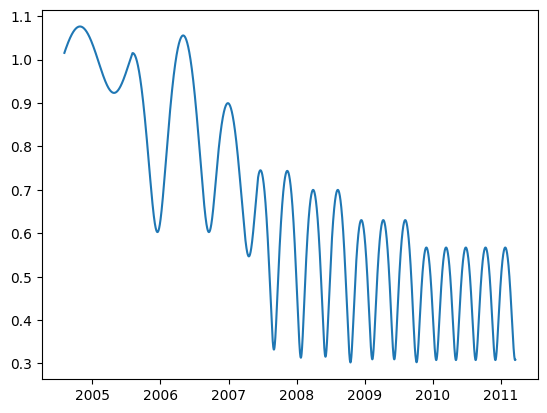

In [20]:

#MESSENGER

# Start date
start_date_mes = datetime.datetime(2004, 8, 4)

# End date
end_date_mes = datetime.datetime(2011, 3,18)

times_mes=[]

# Generate datetimes with increments of dt hours until the end date
current_date = start_date_mes
while current_date <= end_date_mes:
    times_mes.append(current_date)
    current_date += datetime.timedelta(hours=dt)

    

def mes_furnish(kernels_path):
    mes_path = kernels_path+'messenger/'
  
    #put the latest file here manually
    mes_kernel = 'msgr_040803_110601_120401_od216sc.bsp'
    spiceypy.furnsh(os.path.join(mes_path, mes_kernel))
    print(mes_kernel)

    
    generic_path = kernels_path+'generic/'  
    generic_kernels = os.listdir(generic_path)
    print(generic_kernels)
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))


def get_mes_pos(t,kernels_path):

    pos = spiceypy.spkpos("MESSENGER", spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_mes_positions(time_series,kernels_path):
    positions = []
    for t in time_series:
        position = get_mes_pos(t,kernels_path)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions

    
mes_furnish(kernels_path)    
print(kernels_path)
mes=get_mes_positions(times_mes,kernels_path)
plt.plot(mes.time,mes.r)

### STEREO-B

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: x and y must have same first dimension, but have shapes (34729,) and (7,)

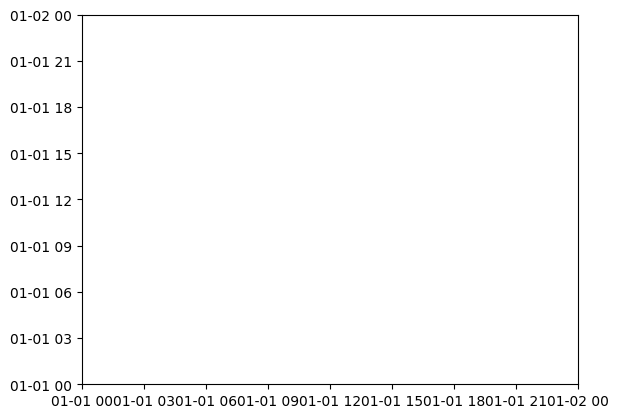

In [45]:

# Start date
start_date_stb = datetime.datetime(2010, 4, 1)

# End date
end_date_stb = datetime.datetime(2014, 3,18)

times_stb=[]

# Generate datetimes with increments of dt hours until the end date
current_date = start_date_stb
while current_date <= end_date_stb:
    times_stb.append(current_date)
    current_date += datetime.timedelta(hours=dt)
    

#STEREO-A and STEREO-B
def furnish_stereo(kernel_path,aorb):

    #need to load both directories
    stereo_kernel_path = kernel_path+'stereo'+aorb+'_predicted/'

    stereoa_kernels = os.listdir(stereo_kernel_path)
    for kernel in stereoa_kernels:
        spiceypy.furnsh(os.path.join(stereo_kernel_path, kernel))
    
    stereo_kernel_path = kernel_path+'stereo'+aorb+'/'

    stereoa_kernels = os.listdir(stereo_kernel_path)
    for kernel in stereoa_kernels:
        spiceypy.furnsh(os.path.join(stereo_kernel_path, kernel))
    
    
    
    generic_path = kernel_path+'generic/'
    generic_kernels = os.listdir(generic_path)
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))




def get_pos(t,name):    

    pos = spiceypy.spkpos(name, spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_emma_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_sc_pos(time, name):
    
    position = get_pos(time, name)
    return position

kernels_file='stereob/behind_2009_049_definitive_predict.epm.bsp'

#files from
#https://soho.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/


furnish_stereo(kernels_path,'b') 

coords=get_sc_pos(times_stb,"STEREO BEHIND")


plt.plot(coords[0],coords)
#plt.plot(coords.time,coords.r)

## older code with astrospice


In [3]:
def wind_positions_heeq(start_year, path=wind_path):
    
    end = datetime.datetime.utcnow().date()

    files = os.listdir(wind_path)
    files.sort()
    data_files = [os.path.join(wind_path, f) for f in files]
            
    for i in np.arange(start_year, end.year+1, 1):
        
        #this is the path for the predicted orbits of Wind (predicted up to Sept. 30th 2023), GSE-coordinates in km
        data_url = f'https://spdf.gsfc.nasa.gov/pub/data/wind/orbit/pre_or/{i}/'
        soup = BeautifulSoup(urlopen(data_url), 'html.parser')
        for link in soup.find_all('a'):
            href = link.get('href')
            if href is not None and href.startswith('wi_or_pre_'):
                filename = href.split('/')[-1]
                fname = filename.split('_')
                date = fname[3]
                version = int(fname[4][1:3])
                
                if np.size(data_files)>0:
                    for i in range(1, len(data_files)):
                        fname_loc = data_files[i].split('_')
                        date_loc = fname_loc[3]
                        version_loc = int(fname_loc[4][1:3])
                        if date == date_loc and version != version_loc:
                            os.remove(data_files[i])
                            print('Deleted', data_files[i])
                
                if os.path.isfile(f"{path}{filename}") == True:
                    print(f'{filename} has already been downloaded.')
                
                else:
                    urllib.request.urlretrieve(data_url+href, f"{path}{filename}")
                    print(f'Successfully downloaded {filename}')


    files1 = os.listdir(wind_path)
    files1.sort()
    data_files1 = [os.path.join(wind_path, f) for f in files1]
    
    time_wind=np.zeros(0,dtype=[('time',object)])
    gse_x=np.zeros(0)
    gse_y=np.zeros(0)
    gse_z=np.zeros(0)

    for i in np.arange(1,len(data_files1)):
        wind_data = cdflib.CDF(data_files1[i])

        gse=wind_data.varget('GSE_POS')
        gse_x1=gse[:,0]*u.km.to(u.au)
        gse_y1=gse[:,1]*u.km.to(u.au)
        gse_z1=gse[:,2]*u.km.to(u.au)

        gse_x=np.append(gse_x,gse_x1)
        gse_y=np.append(gse_y,gse_y1)
        gse_z=np.append(gse_z,gse_z1)

        time_wind_epoch=wind_data.varget('Epoch')

        time_wind_datetime=parse_time(epochs_astropy.CDFAstropy.convert_to_astropy(time_wind_epoch, format=None)).datetime
        time_wind=np.append(time_wind,time_wind_datetime)
    
    #get Earth coordinates in HEE using astrospice
    #dt = 10min, because cdf-files have a 10min resolution as well
    dt = TimeDelta(10 * u.minute)
    
    times = Time(np.arange(Time(time_wind[0]), Time(time_wind[-1])+dt, dt))
    coords_earth = astrospice.generate_coords('Earth', times)
    coords_earth_hee = coords_earth.transform_to(HeliocentricEarthEcliptic())
    [earth_hee_x, earth_hee_y, earth_hee_z] = hd.sphere2cart(coords_earth_hee.distance.to(u.au).value, np.deg2rad(-coords_earth_hee.lat.value+90), np.deg2rad(coords_earth_hee.lon.value))
    
    wind = np.zeros(np.size(time_wind),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    wind = wind.view(np.recarray)
    wind.time = time_wind
    wind.x = earth_hee_x - gse_x
    wind.y = earth_hee_y - gse_y
    wind.z = earth_hee_z + gse_z
    
    wind = convert_HEE_to_HEEQ(wind)
    
    [wind.r, wind.lat, wind.lon] = hd.cart2sphere(wind.x, wind.y, wind.z)
    
    return wind

In [4]:
def convert_HEE_to_HEEQ(sc_in):
    '''
    for Wind positions: convert HEE to HAE to HEEQ
    '''

    print('conversion HEE to HEEQ')                                
    
    sc=copy.deepcopy(sc_in)
    
    jd=np.zeros(len(sc))
    mjd=np.zeros(len(sc))
        

    for i in np.arange(0,len(sc)):

        jd[i]=parse_time(sc.time[i]).jd
        mjd[i]=float(int(jd[i]-2400000.5)) #use modified julian date    
        
       
        w_hee=[sc.x[i],sc.y[i],sc.z[i]]
        
        #HEE to HAE        
        
        #define T00 and UT
        T00=(mjd[i]-51544.5)/36525.0          
        dobj=sc.time[i]
        UT=dobj.hour + dobj.minute / 60. + dobj.second / 3600. #time in UT in hours   

        #lambda_sun in Hapgood, equation 5, here in rad
        M=np.radians(357.528+35999.050*T00+0.04107*UT)
        LAMBDA=280.460+36000.772*T00+0.04107*UT        
        lambda_sun=np.radians( (LAMBDA+(1.915-0.0048*T00)*np.sin(M)+0.020*np.sin(2*M)) )
        
        #S-1 Matrix equation 12 hapgood 1992, change sign in lambda angle for inversion HEE to HAE instead of HAE to HEE
        c, s = np.cos(-(lambda_sun+np.radians(180))), np.sin(-(lambda_sun+np.radians(180)))
        Sm1 = np.array(((c,s, 0), (-s, c, 0), (0, 0, 1)))
        w_hae=np.dot(Sm1,w_hee)

        #HAE to HEEQ
        
        iota=np.radians(7.25)
        omega=np.radians((73.6667+0.013958*((mjd[i]+3242)/365.25)))                      
        theta=np.arctan(np.cos(iota)*np.tan(lambda_sun-omega))                       
                      
    
        #quadrant of theta must be opposite lambda_sun minus omega; Hapgood 1992 end of section 5   
        #get lambda-omega angle in degree mod 360 and theta in degrees
        lambda_omega_deg=np.mod(np.degrees(lambda_sun)-np.degrees(omega),360)
        theta_node_deg=np.degrees(theta)


        ##if the 2 angles are close to similar, so in the same quadrant, then theta_node = theta_node +pi           
        if np.logical_or(abs(lambda_omega_deg-theta_node_deg) < 1, abs(lambda_omega_deg-360-theta_node_deg) < 1): theta=theta+np.pi                                                                                                          
        
        #rotation around Z by theta
        c, s = np.cos(theta), np.sin(theta)
        S2_1 = np.array(((c,s, 0), (-s, c, 0), (0, 0, 1)))

        #rotation around X by iota  
        iota=np.radians(7.25)
        c, s = np.cos(iota), np.sin(iota)
        S2_2 = np.array(( (1,0,0), (0,c, s), (0, -s, c)) )
                
        #rotation around Z by Omega  
        c, s = np.cos(omega), np.sin(omega)
        S2_3 = np.array( ((c,s, 0), (-s, c, 0), (0, 0, 1)) )
        
        #matrix multiplication to go from HAE to HEEQ components                
        [x_heeq,y_heeq,z_heeq]=np.dot(  np.dot(   np.dot(S2_1,S2_2),S2_3), w_hae) 
        
        sc.x[i]=x_heeq
        sc.y[i]=y_heeq
        sc.z[i]=z_heeq

    
    print('HEE to HEEQ done')  
    
    return sc

In [5]:

def get_positions(dt):
    frame = HeliographicStonyhurst()
    
    ### PSP ###
    kernels_psp = astrospice.registry.get_kernels('psp', 'predict')
    psp_kernel = kernels_psp[0]
    # generate coordinates for whole time coverage in a pre-defined interval
    coverage_psp = psp_kernel.coverage('Solar probe plus')
    times_psp = Time(np.arange(coverage_psp[0], coverage_psp[1], dt))
    coords_psp = astrospice.generate_coords('Solar probe plus', times_psp)
    coords_psp = coords_psp.transform_to(frame)
    
    psp = np.zeros(np.size(times_psp),dtype=[('sc', object),('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    psp = psp.view(np.recarray)
    psp.sc = 'PSP'
    psp.time = times_psp.to_datetime(leap_second_strict='silent')
    psp.r = coords_psp.radius.to(u.au).value
    psp.lon = coords_psp.lon.value #degrees
    psp.lat = coords_psp.lat.value #degrees
    [psp.x, psp.y, psp.z] = hd.sphere2cart(psp.r, np.deg2rad(-psp.lat+90), np.deg2rad(psp.lon))
    
    
    ### SolO ###
    kernels_solo = astrospice.registry.get_kernels('solar orbiter', 'predict')
    solo_kernel = kernels_solo[0]
    coverage_solo = solo_kernel.coverage('Solar orbiter')
    times_solo = Time(np.arange(coverage_solo[0], coverage_solo[1], dt))
    coords_solo = astrospice.generate_coords('Solar orbiter', times_solo)
    coords_solo = coords_solo.transform_to(frame)
    
    solo = np.zeros(np.size(times_solo),dtype=[('sc', object),('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    solo = solo.view(np.recarray)
    solo.sc = 'SolO'
    solo.time = times_solo.to_datetime(leap_second_strict='silent')
    solo.r = coords_solo.radius.to(u.au).value
    solo.lon = coords_solo.lon.value #degrees
    solo.lat = coords_solo.lat.value
    [solo.x, solo.y, solo.z] = hd.sphere2cart(solo.r, np.deg2rad(-solo.lat+90), np.deg2rad(solo.lon))
    
    
    ### Stereo-A ###
    kernels_stereo_recon = astrospice.registry.get_kernels('stereo-a', 'recon')
    times_stereo_recon = Time(np.arange(Time('2006-10-27'), Time('2023-8-1'), dt))
    coords_stereo_recon = astrospice.generate_coords('Stereo ahead', times_stereo_recon)
    coords_stereo_recon = coords_stereo_recon.transform_to(frame)

    stereo_recon = np.zeros(np.size(times_stereo_recon),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    stereo_recon = stereo_recon.view(np.recarray)
    stereo_recon.time = times_stereo_recon.to_datetime(leap_second_strict='silent')
    stereo_recon.r = coords_stereo_recon.radius.to(u.au).value
    stereo_recon.lon = coords_stereo_recon.lon.value #degrees
    stereo_recon.lat = coords_stereo_recon.lat.value
    [stereo_recon.x, stereo_recon.y, stereo_recon.z] = hd.sphere2cart(stereo_recon.r, np.deg2rad(-stereo_recon.lat+90), np.deg2rad(stereo_recon.lon))
    
    kernels_stereo_pred = astrospice.registry.get_kernels('stereo-a', 'predict')
    stereo_kernel_pred = kernels_stereo_pred[0]
    coverage_stereo_pred = stereo_kernel_pred.coverage('Stereo ahead')
    times_stereo_pred = Time(np.arange(times_stereo_recon[-1]+dt, coverage_stereo_pred[1], dt))
    coords_stereo_pred = astrospice.generate_coords('Stereo ahead', times_stereo_pred)
    coords_stereo_pred = coords_stereo_pred.transform_to(frame)

    stereo_pred = np.zeros(np.size(times_stereo_pred),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    stereo_pred = stereo_pred.view(np.recarray)
    stereo_pred.time = times_stereo_pred.to_datetime(leap_second_strict='silent')
    stereo_pred.r = coords_stereo_pred.radius.to(u.au).value
    stereo_pred.lon = coords_stereo_pred.lon.value #degrees
    stereo_pred.lat = coords_stereo_pred.lat.value
    [stereo_pred.x, stereo_pred.y, stereo_pred.z] = hd.sphere2cart(stereo_pred.r, np.deg2rad(-stereo_pred.lat+90), np.deg2rad(stereo_pred.lon))

    stereo = np.zeros(np.size(times_stereo_recon)+np.size(times_stereo_pred),dtype=[('sc', object),('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    stereo = stereo.view(np.recarray)
    
    stereo.sc='STA'
    stereo.time=np.hstack((stereo_recon.time,stereo_pred.time))
    stereo.x=np.hstack((stereo_recon.x,stereo_pred.x))
    stereo.y=np.hstack((stereo_recon.y,stereo_pred.y))
    stereo.z=np.hstack((stereo_recon.z,stereo_pred.z))
    stereo.r=np.hstack((stereo_recon.r,stereo_pred.r))
    stereo.lon=np.hstack((stereo_recon.lon,stereo_pred.lon))
    stereo.lat=np.hstack((stereo_recon.lat,stereo_pred.lat))
    
    
    ### Stereo-B ###
    kernels_stereob_recon = astrospice.registry.get_kernels('stereo-b', 'recon')
    times_stereob_recon = Time(np.arange(Time('2006-10-27'), Time('2014-9-28'), dt))
    coords_stereob_recon = astrospice.generate_coords('Stereo behind', times_stereob_recon)
    coords_stereob_recon = coords_stereob_recon.transform_to(frame)

    stereob_recon = np.zeros(np.size(times_stereob_recon),dtype=[('sc', object),('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    stereob_recon = stereob_recon.view(np.recarray)
    stereob_recon.sc='STB'
    stereob_recon.time = times_stereob_recon.to_datetime(leap_second_strict='silent')
    stereob_recon.r = coords_stereob_recon.radius.to(u.au).value
    stereob_recon.lon = coords_stereob_recon.lon.value #degrees
    stereob_recon.lat = coords_stereob_recon.lat.value
    [stereob_recon.x, stereob_recon.y, stereob_recon.z] = hd.sphere2cart(stereob_recon.r, np.deg2rad(-stereob_recon.lat+90), np.deg2rad(stereob_recon.lon))

    
    ### Bepi ###
    kernels_bepi = astrospice.registry.get_kernels('mpo', 'predict')
    bepi_kernel = kernels_bepi[0]
    coverage_bepi = bepi_kernel.coverage('Bepicolombo mpo')
    times_bepi = Time(np.arange(coverage_bepi[0], coverage_bepi[1], dt))
    coords_bepi = astrospice.generate_coords('Bepicolombo mpo', times_bepi)
    coords_bepi = coords_bepi.transform_to(frame)
    
    bepi_ = np.zeros(np.size(times_bepi),dtype=[('sc', object),('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    bepi_ = bepi_.view(np.recarray)
    bepi_.sc = 'Bepi'
    bepi_.time = times_bepi.to_datetime(leap_second_strict='silent')
    bepi_.r = coords_bepi.radius.to(u.au).value
    bepi_.lon = coords_bepi.lon.value #degrees
    bepi_.lat = coords_bepi.lat.value
    [bepi_.x, bepi_.y, bepi_.z] = hd.sphere2cart(bepi_.r, np.deg2rad(-bepi_.lat+90), np.deg2rad(bepi_.lon))
    
    
    ### Earth ###
    times_earth = Time(np.arange(Time('1995-1-1'), Time('2035-1-1'), dt))
    coords_earth = astrospice.generate_coords('Earth', times_earth)
    coords_earth = coords_earth.transform_to(frame)
    
    earth = np.zeros(np.size(times_earth),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    earth = earth.view(np.recarray)
    earth.time = times_earth.to_datetime(leap_second_strict='silent')
    earth.r = coords_earth.radius.to(u.au).value
    earth.lon = coords_earth.lon.value #degrees
    earth.lat = coords_earth.lat.value
    [earth.x, earth.y, earth.z] = hd.sphere2cart(earth.r, np.deg2rad(-earth.lat+90), np.deg2rad(earth.lon))
    
    
    ### Wind ###
    wind = np.zeros(np.size(times_earth),dtype=[('sc', object), ('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    wind = wind.view(np.recarray)
    wind.sc = 'Wind'
    wind.time = earth.time
    wind.x = earth.x - 0.01
    wind.y = earth.y
    wind.z = earth.z
    [wind.r, wind_lat, wind_lon] = hd.cart2sphere(wind.x, wind.y, wind.z)
    wind.lat = np.rad2deg(wind_lat)
    wind.lon = np.rad2deg(wind_lon)

    
    ### Mercury ###
    coords_mercury = astrospice.generate_coords(1, earth.time)
    coords_mercury = coords_mercury.transform_to(frame)
    
    mercury = np.zeros(np.size(earth.time),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    mercury = mercury.view(np.recarray)
    mercury.time = earth.time
    mercury.r = coords_mercury.radius.to(u.au).value
    mercury.lon = coords_mercury.lon.value #degrees
    mercury.lat = coords_mercury.lat.value
    [mercury.x, mercury.y, mercury.z] = hd.sphere2cart(mercury.r, np.deg2rad(-mercury.lat+90), np.deg2rad(mercury.lon))
    
    
    ### Venus ###
    coords_venus = astrospice.generate_coords(2, earth.time)
    coords_venus = coords_venus.transform_to(frame)
    
    venus = np.zeros(np.size(earth.time),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    venus = venus.view(np.recarray)
    venus.time = earth.time
    venus.r = coords_venus.radius.to(u.au).value
    venus.lon = coords_venus.lon.value #degrees
    venus.lat = coords_venus.lat.value
    [venus.x, venus.y, venus.z] = hd.sphere2cart(venus.r, np.deg2rad(-venus.lat+90), np.deg2rad(venus.lon))
    
    
    ### Mars ###
    coords_mars = astrospice.generate_coords(4, earth.time)
    coords_mars = coords_mars.transform_to(frame)

    mars = np.zeros(np.size(earth.time),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    mars = mars.view(np.recarray)
    mars.time = earth.time
    mars.r = coords_mars.radius.to(u.au).value
    mars.lon = coords_mars.lon.value #degrees
    mars.lat = coords_mars.lat.value
    [mars.x, mars.y, mars.z] = hd.sphere2cart(mars.r, np.deg2rad(-mars.lat+90), np.deg2rad(mars.lon))
    
    
    ### Jupiter ###
    coords_jupiter = astrospice.generate_coords(5, earth.time)
    coords_jupiter = coords_jupiter.transform_to(frame)
    
    jupiter = np.zeros(np.size(earth.time),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    jupiter = jupiter.view(np.recarray)
    jupiter.time = earth.time
    jupiter.r = coords_jupiter.radius.to(u.au).value
    jupiter.lon = coords_jupiter.lon.value #degrees
    jupiter.lat = coords_jupiter.lat.value
    [jupiter.x, jupiter.y, jupiter.z] = hd.sphere2cart(jupiter.r, np.deg2rad(-jupiter.lat+90), np.deg2rad(jupiter.lon))
    
    
    ### Saturn ###
    coords_saturn = astrospice.generate_coords(6, earth.time)
    coords_saturn = coords_saturn.transform_to(frame)
    
    saturn = np.zeros(np.size(earth.time),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    saturn = saturn.view(np.recarray)
    saturn.time = earth.time
    saturn.r = coords_saturn.radius.to(u.au).value
    saturn.lon = coords_saturn.lon.value #degrees
    saturn.lat = coords_saturn.lat.value
    [saturn.x, saturn.y, saturn.z] = hd.sphere2cart(saturn.r, np.deg2rad(-saturn.lat+90), np.deg2rad(saturn.lon))
    
    
    ### Uranus ###
    coords_uranus = astrospice.generate_coords(7, earth.time)
    coords_uranus = coords_uranus.transform_to(frame)
    
    uranus = np.zeros(np.size(earth.time),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    uranus = uranus.view(np.recarray)
    uranus.time = earth.time
    uranus.r = coords_uranus.radius.to(u.au).value
    uranus.lon = coords_uranus.lon.value #degrees
    uranus.lat = coords_uranus.lat.value
    [uranus.x, uranus.y, uranus.z] = hd.sphere2cart(uranus.r, np.deg2rad(-uranus.lat+90), np.deg2rad(uranus.lon))
    
    
    ### Neptune ###
    coords_neptune = astrospice.generate_coords(8, earth.time)
    coords_neptune = coords_neptune.transform_to(frame)
    
    neptune = np.zeros(np.size(earth.time),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    neptune = neptune.view(np.recarray)
    neptune.time = earth.time
    neptune.r = coords_neptune.radius.to(u.au).value
    neptune.lon = coords_neptune.lon.value #degrees
    neptune.lat = coords_neptune.lat.value
    [neptune.x, neptune.y, neptune.z] = hd.sphere2cart(neptune.r, np.deg2rad(-neptune.lat+90), np.deg2rad(neptune.lon))  
    
    return [psp, solo, stereo, stereob_recon, bepi_, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune]


In [6]:
### SAVE SPACECRAFT POSITIONS ###

# get data in 1 min resolution
data_1min = get_positions(TimeDelta(1*u.minute))

# get data in rad/mdates
data_new_1min = copy.deepcopy(data_1min)

for i in range(len(data_1min)):
    data_new_1min[i].lat = np.deg2rad(data_1min[i].lat)
    data_new_1min[i].lon = np.deg2rad(data_1min[i].lon)
    data_new_1min[i].time = mdates.date2num(data_1min[i].time)

# get data in 1 hour resolution
data_1h = get_positions(TimeDelta(1*u.hour))

#get data in rad/mdates
data_new_1h = copy.deepcopy(data_1h)

for i in range(len(data_1h)):
    data_new_1h[i].lat = np.deg2rad(data_1h[i].lat)
    data_new_1h[i].lon = np.deg2rad(data_1h[i].lon)
    data_new_1h[i].time = mdates.date2num(data_1h[i].time)

pickle.dump(data_1min, open( 'data/newdata/positions_psp_solo_sta_bepi_wind_planets_HEEQ_1min_degrees.p', "wb" ) ) 
pickle.dump(data_new_1min, open( 'data/newdata/positions_psp_solo_sta_bepi_wind_planets_HEEQ_1min_rad.p', "wb" ) ) 
pickle.dump(data_1h, open( 'data/newdata/positions_psp_solo_sta_bepi_wind_planets_HEEQ_1hour_degrees.p', "wb" ) )
pickle.dump(data_new_1h, open( 'data/newdata/positions_psp_solo_sta_bepi_wind_planets_HEEQ_1hour_rad.p', "wb" ) )

#[psp, solo, stereo, stereob_recon, bepi_, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune] = pickle.load( open( 'data/newdata/positions_psp_solo_sta_bepi_wind_planets_HEEQ_1min_degrees.p', "rb" ) )


HTTPError: HTTP Error 404: Not Found

In [ ]:
#### PLOT SPACECRAFT POSITIONS ####

fig = plt.figure(1, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(psp.lon), psp.r, s=2)
plt.show()

fig = plt.figure(2, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(solo.lon), solo.r, s=2)
plt.show()

fig = plt.figure(3, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(stereo.lon), stereo.r, s=2)
plt.show()

fig = plt.figure(4, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(wind.lon), wind.r, s=2)
plt.show()

fig = plt.figure(5, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(earth.lon), earth.r, s=2)
ax.scatter(np.deg2rad(mercury.lon), mercury.r, s=2)
ax.scatter(np.deg2rad(venus.lon), venus.r, s=2)
ax.scatter(np.deg2rad(mars.lon), mars.r, s=2)
ax.scatter(np.deg2rad(jupiter.lon), jupiter.r, s=2)
ax.scatter(np.deg2rad(saturn.lon), saturn.r, s=2)
ax.scatter(np.deg2rad(uranus.lon), uranus.r, s=2)
ax.scatter(np.deg2rad(neptune.lon), neptune.r, s=2)
plt.show()

In [7]:

frame=HeliographicStonyhurst()
### Earth ###
dt = TimeDelta(60 * u.minute)
times_earth = Time(np.arange(Time('2018-1-1'), Time('2019-1-1'), dt))
coords_earth = astrospice.generate_coords('Earth', times_earth)
coords_earth = coords_earth.transform_to(frame)

earth = np.zeros(np.size(times_earth),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
earth = earth.view(np.recarray)
earth.time = times_earth.to_datetime(leap_second_strict='silent')
earth.r = coords_earth.radius.to(u.au).value
earth.lon = coords_earth.lon.value #degrees
earth.lat = coords_earth.lat.value
[earth.x, earth.y, earth.z] = hd.sphere2cart(earth.r, np.deg2rad(-earth.lat+90), np.deg2rad(earth.lon))

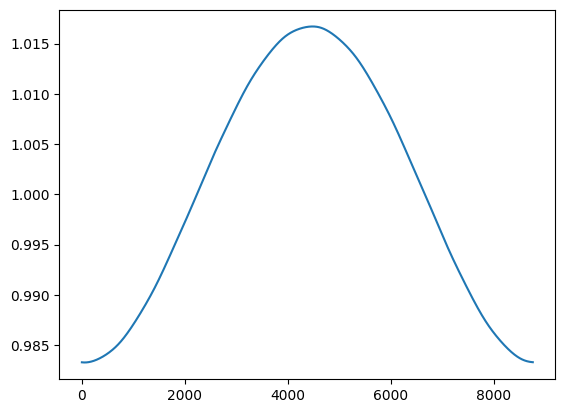

In [8]:
plt.plot(earth.r)




In [9]:
pwd

'/Users/chris/python/heliocats'

#### USE spicepy for Earth in ECLIPJ2000 for Bepi

https://gist.github.com/kerel-fs/40dc8e80c3652f276ea580ab87f32ccd

In [10]:

import spiceypy
from sunpy.time import TimeRange
timerange = TimeRange('2020-02-10', 1*u.year)
times = [timerange.start.datetime]
t = times[0]
while t < timerange.end:
    t = t+ datetime.timedelta(hours=24)
    times.append(t)

    
time_spice = [spiceypy.str2et(t.strftime('%Y-%m-%d %H:%M')) for t in times]
    
spice_files = ['../data/kernels/generic/naif0012.tls', 
               '../data/kernels/generic/de430.bsp',
               '../data/kernels/generic/pck00010.tpc',
               '../data/kernels/solo/solo_ANC_soc-orbit-stp_20200210-20301120_312_V1_00350_V01.bsp']    
spiceypy.furnsh(spice_files)

positions_earth, lightTimes_earth = spiceypy.spkezr('Earth', time_spice, 'ECLIPJ2000', 'NONE', 'Sun')

pos_earth = np.array(positions_earth)[:, :3] * u.km

earth_x_ej2 = pos_earth[:, 0].to(u.au).value
earth_y_ej2 = pos_earth[:, 1].to(u.au).value
earth_z_ej2 = pos_earth[:, 2].to(u.au).value


earth_x_ej2


SpiceNOLEAPSECONDS: 
================================================================================

Toolkit version: CSPICE_N0067

SPICE(NOLEAPSECONDS) --

The variable that points to the leapseconds (DELTET/DELTA_AT) could not be located in the kernel pool.  It is likely that the leapseconds kernel has not been loaded.

str2et_c --> STR2ET --> TTRANS

================================================================================

In [ ]:
plt.plot(earth_y_ej2)

In [ ]:
time_spice